In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from tqdm import tqdm
from sympy import Symbol
from pathlib import Path
import centrex_TlF as centrex
import matplotlib.pyplot as plt

import sys
sys.path.append("../../..")
from utils.plot_utils import set_fontsize

In [2]:
nprocs_python = 6 # processes for python
nprocs_julia = 6 # processes for julia

# Γ
Γ = 1.56e6*2*np.pi

# TlF temperature
T = 6.3

# Define all involved states

# ground state J levels
ground_Js = [1,2,3]

# excited state quantum numbers
excited_Js = [2]
excited_F1s = [5/2]
excited_Fs= [3]
excited_Ps = [+1]

# Settings for transitions

# min and max J level to look for mixing in the B state
excited_Jmin = 1
excited_Jmax = 4


# main laser transition R(1) F'=3 F1'=5/2

ground_main_approx = 1*centrex.CoupledBasisState(J=1,F1=3/2,F=2,mF=0,I1=1/2,I2=1/2,electronic_state='X', 
                                         P = (-1)**1, Omega = 0)
excited_main_approx = 1*centrex.CoupledBasisState(J=2,
                                          F1=5/2,
                                          F=3,
                                          mF=0,I1=1/2,I2=1/2, electronic_state='B', P = +1, Omega = 1)
# ground laser J
laser_J = [1]

transitions = [{'ground main approx': ground_main_approx, 
                'excited main approx': excited_main_approx,
                'ground states approx': 1*centrex.states.generate_coupled_states_ground(laser_J),
                'excited states approx': 1*centrex.states.generate_coupled_states_excited(
                                                excited_Js, excited_Fs, excited_F1s, excited_Ps),
                'main polarization': np.array([0,0,1]),
                'polarizations': [np.array([0,0,1]), np.array([1,0,0])],
                'polarization symbols': [Symbol("Plz"), Symbol("Plx")],
                'Ω symbol': Symbol('Ωl', complex = True),
                'Δ symbol': Symbol('δl'),
                'description': "laser transition"
               }]

# make sure that subsequent transitions don't have their excited state be the ground state of another transition
transitions.append(
    {
        'ground main approx': 1*centrex.CoupledBasisState(J=1,F1=3/2,F=1,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = (-1)**1, Omega = 0),
        'excited main approx': 1*centrex.CoupledBasisState(J=2,F1=5/2,F=2,mF=0,I1=1/2,I2=1/2, electronic_state='X', P = (-1)**2, Omega = 0),
        'ground states approx': 1*centrex.states.generate_coupled_states_ground([1]),
        'excited states approx': 1*centrex.states.generate_coupled_states_ground([2]),
        'main polarization': np.array([0,0,1]),
        'polarizations': [np.array([0,0,1]), np.array([0,1,0])],
        'polarization symbols': [Symbol("Pμ12z"), Symbol("Pμ12y")],
        'Ω symbol': Symbol('Ωμ12', complex = True),
        'Δ symbol': Symbol('δμ12'),
        'description': "J12 microwave transition"
    }
)

transitions.append(
    {
        'ground main approx': 1*centrex.CoupledBasisState(J=3,F1=5/2,F=3,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = (-1)**1, Omega = 0),
        'excited main approx': 1*centrex.CoupledBasisState(J=2,F1=5/2,F=2,mF=0,I1=1/2,I2=1/2, electronic_state='X', P = (-1)**2, Omega = 0),
        'ground states approx': 1*centrex.states.generate_coupled_states_ground([3]),
        'excited states approx': 1*centrex.states.generate_coupled_states_ground([2]),
        'main polarization': np.array([0,0,1]),
        'polarizations': [np.array([0,0,1]), np.array([0,1,0])],
        'polarization symbols': [Symbol("Pμ23z"), Symbol("Pμ23y")],
        'Ω symbol': Symbol('Ωμ23', complex = True),
        'Δ symbol': Symbol('δμ23'),
        'description': "J23 microwave transition"
    }
)

# sanity check to ensure no ground states for one transition are an
# excited state for another transition
centrex.couplings.utils.check_transitions(transitions)

In [3]:
# specify states to combine into a single level 
# e.g. only decay to these states and not interested in population distribution there
slice_compact = None

### Specifying parameters and the ode function preamble
Allows for setting parameters to be time dependent (e.g. sin(t), cos(t))

In [4]:
# order of parameters in p
parameters = ['Ωl', 'δl', 'ωp', 'ϕp', 'y0', 'vy', 'vz', 'μzlaser', 'σylaser', 'σzlaser', 'β', 'ωphase',
              'Ωμ12', 'δμ12', 'ωpμ12', 'ϕpμ12', 'Ωμ23', 'δμ23', 'ωpμ23', 'ϕpμ23']

In [5]:
preamble = """function Lindblad_rhs!(du, ρ, p, t)
\t@inbounds begin
\t\tΩl = p[1]
\t\tδl = p[2]
\t\tωp = p[3]
\t\tϕp = p[4]
\t\ty0 = p[5]
\t\tvy = p[6]
\t\tvz = p[7]
\t\tμzlaser = p[8]
\t\tσylaser = p[9]
\t\tσzlaser = p[10]
\t\tβ = p[11]
\t\tωphase = p[12]
\t\tΩμ12 = p[13]
\t\tΩμ12ᶜ = conj(Ωμ12)
\t\tδμ12 = p[14]
\t\tωpμ12 = p[15]
\t\tϕpμ12 = p[16]
\t\tΩμ23 = p[17]
\t\tΩμ23ᶜ = conj(Ωμ23)
\t\tδμ23 = p[18]
\t\tωpμ23 = p[19]
\t\tϕpμ23 = p[20]


\t\tΩl = Ωl .* gaussian_2d(vz*t, y0+vy*t, 1., μzlaser, 0., σzlaser, σylaser) .* phase_modulation(t, β, ωphase)
\t\tΩlᶜ = conj(Ωl)

\t\tPl = sin(ωp*t + ϕp)
\t\tPlx = (1-Pl)/2
\t\tPlz = (1+Pl)/2

\t\tPμ12 = sin(ωpμ12*t + ϕpμ12)
\t\tPμ12z = (1-Pμ12)/2
\t\tPμ12y = (1+Pμ12)/2

\t\tPμ23 = sin(ωpμ23*t + ϕpμ23)
\t\tPμ23z = (1-Pμ23)/2
\t\tPμ23y = (1+Pμ23)/2
"""

In [6]:
odepars = centrex.lindblad.odeParameters(parameters)
odepars.Ωl = Γ
odepars.ωp = Γ
odepars

odeParameters(Ωl: 9.80e+06, δl: 0.00e+00, ωp: 9.80e+06, ϕp: 0.00e+00, y0: 0.00e+00, vy: 0.00e+00, vz: 0.00e+00, μzlaser: 0.00e+00, σylaser: 0.00e+00, σzlaser: 0.00e+00, β: 0.00e+00, ωphase: 0.00e+00, Ωμ12: 0.00e+00, δμ12: 0.00e+00, ωpμ12: 0.00e+00, ϕpμ12: 0.00e+00, Ωμ23: 0.00e+00, δμ23: 0.00e+00, ωpμ23: 0.00e+00, ϕpμ23: 0.00e+00)

## Start calculations for Hamiltonian and transitions

In [7]:
%%time 
ground_states_approx = centrex.states.generate_coupled_states_ground(ground_Js)
excited_states_approx = centrex.states.generate_coupled_states_excited(excited_Js, excited_Fs, 
                                                                       excited_F1s, excited_Ps)

ground_states, excited_states, QN, H_int, V_ref_int = centrex.hamiltonian.generate_total_reduced_hamiltonian(
                                            ground_states_approx, excited_states_approx)

Wall time: 11.5 s


In [8]:
%%time
couplings = []
for transition in transitions:
    coupling = centrex.couplings.generate_coupling_field(
                                        transition['ground main approx'],
                                        transition['excited main approx'],
                                        transition['ground states approx'],
                                        transition['excited states approx'],
                                        H_int, QN, V_ref_int, 
                                        pol_main = transition['main polarization'],
                                        pol_vec = transition['polarizations'],
                                        nprocs = nprocs_python)
    couplings.append(coupling)

Wall time: 6min 21s


In [9]:
%%time
H_symbolic = centrex.lindblad.generate_total_symbolic_hamiltonian(QN, H_int, couplings, transitions, 
                                                                slice_compact = slice_compact)

Wall time: 2.28 s


In [10]:
# still something going wrong with rotating frame approximation, manually adjust
levels_J1 = centrex.utils.J_levels(1)
levels_J2 = centrex.utils.J_levels(2)
levels_J3 = centrex.utils.J_levels(3)
idx_J1 = [s.find_largest_component() for s in QN].index(transitions[1]['ground main approx'].find_largest_component())
val = H_symbolic[idx_J1, idx_J1]
for idx in range(levels_J1):
    H_symbolic[idx, idx] -= val

idx_J2 = [s.find_largest_component() for s in QN].index(transitions[1]['excited main approx'].find_largest_component())
val = H_symbolic[idx_J2, idx_J2]
val = [v for v in val.atoms() if v.is_number][0]
for idx in range(levels_J1, levels_J1+levels_J2):
    H_symbolic[idx, idx] -= val
    
idx_B = [s.find_largest_component() for s in QN].index(transitions[0]['excited main approx'].find_largest_component())
val = H_symbolic[idx_B, idx_B]
val = [v for v in val.atoms() if v.is_number][0]
for idx in [idx for idx, s in enumerate(QN) if s.find_largest_component().electronic_state == 'B']:
    H_symbolic[idx, idx] -= val

In [11]:
%%time
C_array = centrex.couplings.collapse_matrices(QN, ground_states, excited_states, gamma = Γ, 
                                            slice_compact = slice_compact)
system = centrex.lindblad.generate_system_of_equations_symbolic(H_symbolic, C_array, progress = False, fast = True)

Wall time: 2min 5s


In [12]:
%%time
# convert matrix to system of equations code
code_lines = centrex.lindblad.system_of_equations_to_lines(system, nprocs = nprocs_python)

Wall time: 2min 53s


# Solving ODE system with Julia
Need to install Julia and add the following packages to Julia:  
* [DifferentialEquations](https://diffeq.sciml.ai/stable/)
* [Trapz](https://github.com/francescoalemanno/Trapz.jl)

And install [PyJulia](https://pyjulia.readthedocs.io/en/latest/index.html) for python.  

In [13]:
# import julia
# julia.install()

In [14]:
from julia import Main
centrex.lindblad.initialize_julia(nprocs = nprocs_julia)

_ = centrex.lindblad.generate_ode_fun_julia(preamble, code_lines)

# generate initial conditions
ρ_ini = centrex.utils.generate_population_states(list(range(12)), H_symbolic.shape[0])
centrex.lindblad.setup_variables_julia(Γ, ρ_ini)
odepars.generate_p_julia()

Initialized Julia with 6 processes


In [15]:
Main.eval("""
@everywhere function gaussian_2d(x::Float64, y::Float64, a::Float64, μx::Float64, μy::Float64, σx::Float64, σy::Float64)::Float64
    a.*exp(.- ((x.-μx).^2 ./ (2 .* σx.*σx) + (y.-μy).^2 ./ (2 .* σy.*σy)))
end

@everywhere function phase_modulation(t::Float64, β::Float64, ω::Float64)
    return exp(1im.*β.*sin(ω.*t))
end
""")

### Setting up the ODE problem to solve
`tmp = 0` is just to prevent `Main.eval` from outputting the problem in the notebook.  
The ODEProblem takes a function to solve (`Lindblad_rhs!` in this case), initial conditions `ρ_ini`, a timespan `tspan` an additional arguments for the ODE function, denoted here by `p` 

In [16]:
odepars = centrex.lindblad.odeParameters(parameters)
odepars.Ωl = 0.18*Γ
odepars.ωp = Γ
odepars.σylaser = 1e-2/2
odepars.σzlaser = 1e-2/2
odepars.μzlaser = 4*odepars.σzlaser
odepars.y0 = 0
odepars.vz = 184
odepars.vy = 0
odepars.β = 3.8
odepars.ωphase = 2*np.pi*1.6e6

odepars.Ωμ12 = 0.18*Γ
odepars.ωpμ12 = 2*np.pi*1e6
odepars.Ωμ23 = 0.18*Γ
odepars.ωpμ23 = 2*np.pi*1e6
setattr(odepars, dir(odepars)[-1], np.pi)

odepars.generate_p_julia()
print(odepars.to_units_Γ(Γ))

odeParameters(Ωl: 0.18, δl: 0.00, ωp: 1.00, ϕp: 0.00e+00, y0: 0.00e+00, vy: 0.00e+00, vz: 1.84e+02, μzlaser: 2.00e-02, σylaser: 5.00e-03, σzlaser: 5.00e-03, β: 3.80e+00, ωphase: 1.03, Ωμ12: 0.18, δμ12: 0.00, ωpμ12: 0.64, ϕpμ12: 0.00e+00, Ωμ23: 0.18, δμ23: 0.00, ωpμ23: 0.64, ϕpμ23: 3.14e+00)


In [17]:
Main.du = np.zeros(ρ_ini.shape, dtype = complex)
Main.eval("@time tmp = Lindblad_rhs!(du, ρ, p, 0.0);");

In [18]:
%%time
Main.eval(f"""
tspan = (0.0, {8*odepars.σzlaser / odepars.vz})
prob = ODEProblem(Lindblad_rhs!,ρ,tspan,p)
""");

In [19]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), abstol = 1e-7, reltol = 1e-4, progress = false);
tmp = 0
""");

Wall time: 21.4 s


0

In [20]:
ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("sol.t")

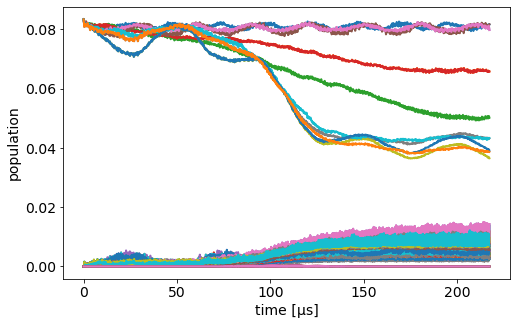

In [21]:
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ls = '-'
    if idx in range(0,len(pop_results)):
        s = QN[idx].find_largest_component()
        if s.F is None:
            label = f'{s.electronic_state}, J={s.J}'
        else:
            label = f'{s.electronic_state}, J={s.J}, F={s.F:.0f}, F1={s.F1}, mF={s.mF:+.0f}'
        ax.plot(t_array*1e6, pop, lw = 2, label = label, ls = ls)
#         ax.plot(t_array, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$", ls = ls)

ax.set_xlabel('time [μs]')
ax.set_ylabel('population')
# ax.legend(fontsize = 14)
set_fontsize(ax, 14)

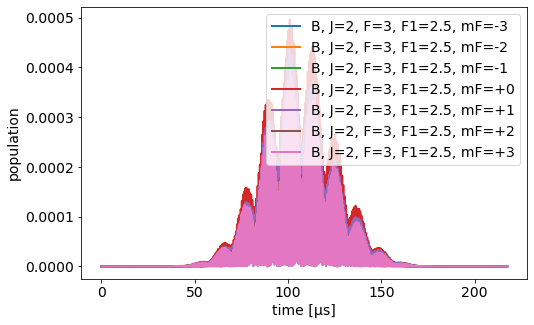

In [22]:
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ls = '-'
    if idx >= H_symbolic.shape[0] - len(excited_states):
        s = QN[idx].find_largest_component()
        label = f'{s.electronic_state}, J={s.J}, F={s.F:.0f}, F1={s.F1}, mF={s.mF:+.0f}'
        ax.plot(t_array*1e6, pop, lw = 2, label = label, ls = ls)
#         ax.plot(t_array*1e6, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$", ls = ls)

ax.set_xlabel('time [μs]')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

## Scan detuning

In [23]:
odepars.Ωl = 0.4*Γ
odepars.ωp = 1*Γ
print(odepars.to_units_Γ(Γ))
odepars.generate_p_julia()

odeParameters(Ωl: 0.40, δl: 0.00, ωp: 1.00, ϕp: 0.00e+00, y0: 0.00e+00, vy: 0.00e+00, vz: 1.84e+02, μzlaser: 2.00e-02, σylaser: 5.00e-03, σzlaser: 5.00e-03, β: 3.80e+00, ωphase: 1.03, Ωμ12: 0.18, δμ12: 0.00, ωpμ12: 0.64, ϕpμ12: 0.00e+00, Ωμ23: 0.18, δμ23: 0.00, ωpμ23: 0.64, ϕpμ23: 3.14e+00)


In [24]:
# ρ_ini = centrex.utils.generate_thermal_J(ground_Js, len(excited_states), T, normalized = True, 
#                                          slice_compact = slice_compact)
ρ_ini = centrex.utils.generate_population_states(list(range(12)), H_symbolic.shape[0])
Main.ρ_ini = ρ_ini
Main.eval("@everywhere ρ_ini = $ρ_ini")

In [25]:
δls = np.linspace(-5,5,101)*Γ

In [26]:
# generate the prob_func to remake the problem for each iteration
centrex.lindblad.setup_parameter_scan_1D(odepars, 'δl', δls)

In [27]:
# generate the output_func to transform the ode solution after integration
n_excited = len(excited_states)
n_states = H_symbolic.shape[0]
centrex.lindblad.setup_state_integral_calculation(list(range(n_states-n_excited+1, n_states+1)))

In [28]:
Main.eval(f"""
tspan = (0.0, {8*odepars.σzlaser / odepars.vz})
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
""");

In [29]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""");

In [30]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(); trajectories = size(params)[1],
            abstol = 1e-8, reltol = 1e-5)
sim.elapsedTime
""")

3980.408672

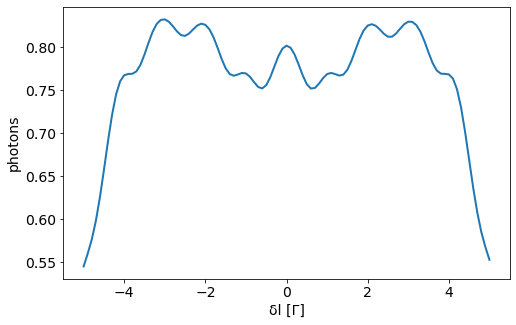

In [31]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Main.params/Main.Γ, np.asarray(Main.sim)*Γ, lw = 2)

ax.set_xlabel('δl [Γ]')
ax.set_ylabel('photons')

set_fontsize(ax, 14)

## Setup with values from RC simulation, with initial thermal population

In [32]:
data_dir = Path('.').absolute().parent.parent.parent / 'with microwaves'
fname = 'laser_mu1mu2_rc_pol_switching_on_apertures_phasemod_2020_10_28_2x_beamheight.npy'
results_array = np.load(data_dir / fname)

In [33]:
# laser power for RC
m = results_array[:,0] == 10000000
# μ1 power for RC
m = m & (results_array[:,1] == 20000000)
# μ2 power for RC
m = m & (results_array[:,2] == 20000000)

δls, vzs, vys, y0s = results_array[m][:,[3,4,5,6]].T

38.39" from cell opening to DET laser.
Start simulation 1" from the start of the laser, i.e. the molecules travel 37.39".

In [34]:
# new y0 positions 1" in front of DET laser
y0s_start = (37.39*25.4*1e-3)/vzs * vys + y0s

In [35]:
params = np.stack([δls, y0s_start, vys, vzs])
Main.params = params
Main.eval("@everywhere params = $params")

In [36]:
_ρ = centrex.utils.generate_thermal_J([0,1,2,3], len(excited_states), T, normalized = True, 
                                         slice_compact = None)
levels_J1 = centrex.utils.J_levels(1)
levels_J2 = centrex.utils.J_levels(2)
levels_J3 = centrex.utils.J_levels(3)
ρ_ini = np.zeros(H_symbolic.shape, dtype = complex)
np.fill_diagonal(ρ_ini[:levels_J1, :levels_J1], np.diag(_ρ)[centrex.utils.J_slice(1)])
np.fill_diagonal(ρ_ini[levels_J1:levels_J1+levels_J2, levels_J1:levels_J1+levels_J2], 
                 np.diag(_ρ)[centrex.utils.J_slice(2)])
np.fill_diagonal(ρ_ini[levels_J1+levels_J2:levels_J1+levels_J2+levels_J3, levels_J1+levels_J2:levels_J1+levels_J2+levels_J3], 
                 np.diag(_ρ)[centrex.utils.J_slice(3)])

Main.ρ_ini = ρ_ini
Main.eval("@everywhere ρ_ini = $ρ_ini")

In [37]:
Main.eval(f"""
tspan = (0.0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
""");

In [38]:
# terminate integration 1" behind the detection laser
Main.eval("""
@everywhere function affect!(integrator)
    terminate!(integrator)
end
@everywhere condition(u,t,integrator) = integrator.p[7]*t > 50.8e-3
cb = DiscreteCallback(condition, affect!)
""");

In [39]:
odepars.Ωl = 0.5*Γ
odepars.ωl = 2*np.pi*1e6
print(odepars.to_units_Γ(Γ))
odepars.generate_p_julia()

odeParameters(Ωl: 0.50, δl: 0.00, ωp: 1.00, ϕp: 0.00e+00, y0: 0.00e+00, vy: 0.00e+00, vz: 1.84e+02, μzlaser: 2.00e-02, σylaser: 5.00e-03, σzlaser: 5.00e-03, β: 3.80e+00, ωphase: 1.03, Ωμ12: 0.18, δμ12: 0.00, ωpμ12: 0.64, ϕpμ12: 0.00e+00, Ωμ23: 0.18, δμ23: 0.00, ωpμ23: 0.64, ϕpμ23: 3.14e+00)


In [40]:
Main.eval(f"""
@everywhere function prob_func_prerc(prob,i,repeat)
    remake(prob,p=[{odepars.Ωl}, params[1,i], {odepars.ωp}, 0, params[2,i], params[3,i], 
                    params[4,i], {odepars.μzlaser}, {odepars.σylaser}, {odepars.σzlaser}, {odepars.β}, 
                    {odepars.ωphase}, 
                    {odepars.Ωμ12}, {odepars.δμ12}, {odepars.ωpμ12}, {getattr(odepars, dir(odepars)[-2])},
                    {odepars.Ωμ23}, {odepars.δμ23}, {odepars.ωpμ23}, {getattr(odepars, dir(odepars)[-1])}])
end
""")

In [41]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob_prerc = EnsembleProblem(prob, prob_func = prob_func_prerc, output_func = output_func);
""");

In [42]:
Main.eval("""
@time sim = solve(ens_prob_prerc, Tsit5(), EnsembleDistributed(); trajectories = size(params)[2],
            abstol = 1e-8, reltol = 1e-5, save_everystep = true, callback = cb)
sim.elapsedTime
""")

29059.2826439

In [43]:
results = np.array(Main.eval("sim.u"))*Γ

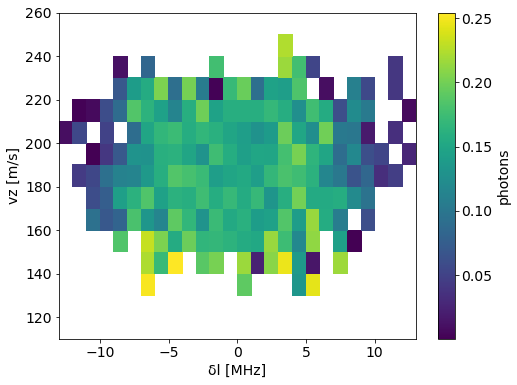

In [44]:
xbins = np.linspace(-13, 13, 27)
ybins = np.linspace(110, 260, 16)

from scipy.stats import norm, binned_statistic_2d

x = params[0,:]/Γ * 1.6
y = params[3,:]
z = results
stat, x_edge, y_edge, bin_number = binned_statistic_2d(x,y,values = z, statistic = 'mean', bins = [xbins, ybins])
X, Y = np.meshgrid(x_edge,y_edge)
            
fig, ax = plt.subplots(figsize = (8,6))
cs = ax.pcolormesh(X, Y, stat.T)

cbar = fig.colorbar(cs)


ax.set_xlabel('δl [MHz]')
ax.set_ylabel(r'vz [m/s]')
cbar.ax.set_ylabel('photons')
set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

## Setup with values from RC simulation, with post-RC population

In [45]:
ρrc = []
for pop in results_array[m][:,-67:][:,4:64]:
    _ρ = np.zeros(ρ_ini.shape, dtype = ρ_ini.dtype)
    np.fill_diagonal(_ρ[:60,:60], pop)
    ρrc.append(_ρ)

38.39" from cell opening to DET laser.
Start simulation 1" from the start of the laser, i.e. the molecules travel 37.39".

In [46]:
# new y0 positions 1" in front of DET laser
y0s_start = (37.39*25.4*1e-3)/vzs * vys + y0s

In [47]:
params = np.stack([δls, y0s_start, vys, vzs])
Main.params = params
Main.eval("@everywhere params = $params")
Main.ρrc = ρrc
Main.eval("@everywhere ρrc = $ρrc")

In [48]:
Main.eval(f"""
tspan = (0.0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
""");

In [49]:
odepars.Ωl = 0.5*Γ
odepars.ωl = 2*np.pi*1e6
print(odepars.to_units_Γ(Γ))
odepars.generate_p_julia()

odeParameters(Ωl: 0.50, δl: 0.00, ωp: 1.00, ϕp: 0.00e+00, y0: 0.00e+00, vy: 0.00e+00, vz: 1.84e+02, μzlaser: 2.00e-02, σylaser: 5.00e-03, σzlaser: 5.00e-03, β: 3.80e+00, ωphase: 1.03, Ωμ12: 0.18, δμ12: 0.00, ωpμ12: 0.64, ϕpμ12: 0.00e+00, Ωμ23: 0.18, δμ23: 0.00, ωpμ23: 0.64, ϕpμ23: 3.14e+00)


In [51]:
Main.eval(f"""
@everywhere function prob_func_postrc(prob,i,repeat)
    remake(prob,p=[{odepars.Ωl}, params[1,i], {odepars.ωp}, 0, params[2,i], params[3,i], 
                    params[4,i], {odepars.μzlaser}, {odepars.σylaser}, {odepars.σzlaser}, 
                    {odepars.β}, {odepars.ωphase}, 
                    {odepars.Ωμ12}, {odepars.δμ12}, {odepars.ωpμ12}, {getattr(odepars, dir(odepars)[-2])},
                    {odepars.Ωμ23}, {odepars.δμ23}, {odepars.ωpμ23}, {getattr(odepars, dir(odepars)[-1])}],
                    u0 = ρrc[i])
end
""")

In [52]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob_postrc = EnsembleProblem(prob, prob_func = prob_func_postrc, output_func = output_func);
""");

In [ ]:
Main.eval("""
@time sim = solve(ens_prob_postrc, Tsit5(), EnsembleDistributed(); trajectories = size(params)[2],
            abstol = 1e-8, reltol = 1e-5, save_everystep = true, callback = cb)
sim.elapsedTime
""")

In [ ]:
results_RC = np.array(Main.eval("sim.u"))*Γ

In [ ]:
xbins = np.linspace(-13, 13, 27)
ybins = np.linspace(110, 260, 16)

from scipy.stats import norm, binned_statistic_2d

x = params[0,:]/Γ * 1.6
y = params[3,:]
z = results_RC
stat, x_edge, y_edge, bin_number = binned_statistic_2d(x,y,values = z, statistic = 'mean', bins = [xbins, ybins])
X, Y = np.meshgrid(x_edge,y_edge)
            
fig, ax = plt.subplots(figsize = (8,6))
cs = ax.pcolormesh(X, Y, stat.T)

cbar = fig.colorbar(cs)


ax.set_xlabel('δl [MHz]')
ax.set_ylabel(r'vz [m/s]')
cbar.ax.set_ylabel('photons')
set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

In [ ]:
xbins = np.linspace(-13, 13, 27)
ybins = np.linspace(110, 260, 16)

from scipy.stats import norm, binned_statistic_2d

x = params[0,:]/Γ * 1.6
y = params[3,:]
z = results_RC/results
stat, x_edge, y_edge, bin_number = binned_statistic_2d(x,y,values = z, statistic = 'mean', bins = [xbins, ybins])
X, Y = np.meshgrid(x_edge,y_edge)
            
fig, ax = plt.subplots(figsize = (8,6))
cs = ax.pcolormesh(X, Y, stat.T)

cbar = fig.colorbar(cs)


ax.set_xlabel('δl [MHz]')
ax.set_ylabel(r'vz [m/s]')
cbar.ax.set_ylabel('ratio')
set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

In [ ]:
# apparent ratio
ratio_measured = results_RC.mean()/results.mean()
ratio_real = results_array[m][:,-67:][:,4:16].sum(axis = 1).mean()/np.diag(ρ_ini.real)[:12].sum()
print(f"ratio measured : {ratio_measured:.2f}")
print(f"ratio real : {ratio_real:.2f}") 
print(f"measured / real : {ratio_measured/ratio_real:.2f}")